# 라이브러리 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDERNAME = 'project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/project


In [ ]:
# %cd /content/drive/MyDrive/project

In [ ]:
import tarfile
import os
from pathlib import Path
import shutil
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# 데이터셋 압축풀기

In [ ]:
fname="data/RoadDamageDataset.tar.gz"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall("data/")
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall("data/")
    tar.close()

# 이미지와 라벨 파일구분

In [ ]:
input_path = Path("data/RoadDamageDataset")
output_path = Path("data/assortedFiles")

try:
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    if not os.path.exists(output_path/'images'):
        os.mkdir(output_path/'images')
    if not os.path.exists(output_path/'labels'):
        os.mkdir(output_path/'labels')
except: raise


for fl in os.listdir(input_path):
    if not(fl.startswith(".")):
        print("Going for ",fl)
        count=0
        num_files=len(os.listdir(input_path/fl/'Annotations'))
        for f in os.listdir(input_path/fl/'Annotations'):
            if not(f.startswith(".")):
                img_name = f.split('.')[0] + '.jpg'
                shutil.copyfile(input_path/fl/'JPEGImages'/img_name, output_path/'images'/img_name)
                shutil.copyfile(input_path/fl/'Annotations'/f, output_path/'labels'/f)
                count+=1
                if count%500==0:
                    print(count,"/",num_files,"done")

Going for  Chiba
Going for  Sumida
500 / 2278 done
1000 / 2278 done
Going for  Muroran
500 / 4290 done
1000 / 4290 done
1500 / 4290 done
2000 / 4290 done
Going for  Adachi
500 / 3300 done
1000 / 3300 done
1500 / 3300 done
Going for  Nagakute
500 / 2732 done
1000 / 2732 done
Going for  Numazu
500 / 4064 done
1000 / 4064 done
1500 / 4064 done
2000 / 4064 done
Going for  Ichihara


# XML 파일에서 데이터를 추출한 다음 비율로 변환하고 txt 파일로 저장

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        if len(info_dict["image_size"] )==3:
            image_w, image_h, image_c = info_dict["image_size"]
        elif len(info_dict["image_size"] )==2:
            image_w, image_h = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("data/assortedFiles/annotations", info_dict["filename"].replace("jpg", "txt"))
    # print(print_buffer)
    # print(save_file_name)
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))



# create a mapping for class to numerical
class_name_to_id_mapping={
 'D00': 0,
 'D01': 1,
 'D10': 2,
 'D11': 3,
 'D20': 4,
 'D30': 5,
 'D40': 6,
 'D43': 7,
 'D44': 8}

label_files_location="data/assortedFiles/labels/"
image_files_location="data/assortedFiles/images/"

if not os.path.isdir("data/assortedFiles/annotations/"):
    os.mkdir("data/assortedFiles/annotations/")

print("Converting xml annotations to txt annotations in yolov5 understandable format")
for l_file in os.listdir(label_files_location):
    info_dict=extract_info_from_xml(label_files_location+l_file)
    convert_to_yolov5(info_dict)

print("Done")

Converting xml annotations to txt annotations in yolov5 understandable format
Done


#  txt 파일을 선택하고 파일에 있는 값에 따라 경계 상자 그리기

[[4.0, 0.161, 0.727, 0.185, 0.243], [2.0, 0.42, 0.924, 0.227, 0.052], [2.0, 0.443, 0.826, 0.313, 0.055], [2.0, 0.372, 0.726, 0.192, 0.065], [1.0, 0.746, 0.839, 0.278, 0.268]]
file is  data/assortedFiles/images/Numazu_20170906131352.jpg


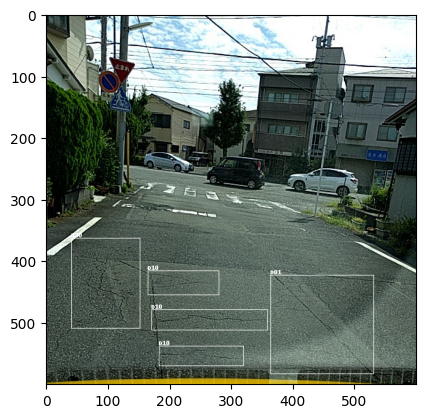

In [ ]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))



# Get any random annotation file
# annotation_file = random.choice(annotations)

annotation_file = "data/assortedFiles/annotations/Numazu_20170906131352.txt"
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
    print(annotation_list)

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
print("file is ",image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# 데이터 분할

In [ ]:
# Read images and annotations
images = [os.path.join('data/assortedFiles/images', x) for x in os.listdir('data/assortedFiles/images')]
annotations = [os.path.join('data/assortedFiles/annotations', x) for x in os.listdir('data/assortedFiles/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

print("Number of images",len(images),"\nNumber of annotation files",len(annotations))
# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)



print("Training:",len(train_images),";Validation: ",len(val_images),";Test:",len(test_images))

if not os.path.isdir("data/finalRoad"):
    os.mkdir("data/finalRoad")

if not os.path.isdir("data/finalRoad/images"):
    os.mkdir("data/finalRoad/images")


if not os.path.isdir("data/finalRoad/labels"):
    os.mkdir("data/finalRoad/labels")


if not os.path.isdir("data/finalRoad/images/train"):
    os.mkdir("data/finalRoad/images/train")

if not os.path.isdir("data/finalRoad/images/val"):
    os.mkdir("data/finalRoad/images/val")

if not os.path.isdir("data/finalRoad/images/test"):
    os.mkdir("data/finalRoad/images/test")


if not os.path.isdir("data/finalRoad/labels/train"):
    os.mkdir("data/finalRoad/labels/train")

if not os.path.isdir("data/finalRoad/labels/val"):
    os.mkdir("data/finalRoad/labels/val")

if not os.path.isdir("data/finalRoad/labels/test"):
    os.mkdir("data/finalRoad/labels/test")



#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        # print(f,destination_folder)
        try:
            shutil.copy(f, destination_folder)
        except:
            pass
            # print(f,"Already there")
            # assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'data/finalRoad/images/train/')
move_files_to_folder(val_images, 'data/finalRoad/images/val/')
move_files_to_folder(test_images, 'data/finalRoad/images/test/')
move_files_to_folder(train_annotations, 'data/finalRoad/labels/train/')
move_files_to_folder(val_annotations, 'data/finalRoad/labels/val/')
move_files_to_folder(test_annotations, 'data/finalRoad/labels/test/')

Number of images 9053 
Number of annotation files 9053
Training: 7242 ;Validation:  905 ;Test: 906


# 분할한 데이터 숫자 확인

In [ ]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [ ]:
print("Number of train images = ",len(os.listdir("data/finalRoad/images/train/")))
print("Number of train annotations = ",len(os.listdir("data/finalRoad/labels/train/")))

print("Number of val images = ",len(os.listdir("data/finalRoad/images/val/")))
print("Number of val annotations = ",len(os.listdir("data/finalRoad/labels/val/")))

print("Number of test images = ",len(os.listdir("data/finalRoad/images/test/")))
print("Number of test annotations = ",len(os.listdir("data/finalRoad/labels/test/")))

Number of train images =  7242
Number of train annotations =  7242
Number of val images =  905
Number of val annotations =  905
Number of test images =  906
Number of test annotations =  906


In [ ]:
import os
!git clone https://github.com/ultralytics/yolov5
os.chdir(r"yolov5")
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
path = Path(os.getcwd())
parent_path=path.parent.absolute()
final_data_path=os.path.join(parent_path,"data","finalRoad")
print(final_data_path)

yaml_data="train: "+final_data_path+"/images/train\n"
yaml_data+="val: "+final_data_path+"/images/val\n"
yaml_data+="test: "+final_data_path+"/images/test\n"

rest_of_yaml_data='''nc: 9
names: ['D00',
        'D01',
        'D10',
        'D11',
        'D20',
        'D30',
        'D40',
        'D43',
        'D44',
]'''

yaml_data=yaml_data+rest_of_yaml_data
print(yaml_data)

yaml_file = open("dataRoad.yaml", "w")
n = yaml_file.write(yaml_data)
yaml_file.close()

/content/drive/MyDrive/project/data/finalRoad
train: /content/drive/MyDrive/project/data/finalRoad/images/train
val: /content/drive/MyDrive/project/data/finalRoad/images/val
test: /content/drive/MyDrive/project/data/finalRoad/images/test
nc: 9
names: ['D00',
        'D01',
        'D10',
        'D11',
        'D20',
        'D30',
        'D40',
        'D43',
        'D44',
]


In [ ]:
! python /content/drive/MyDrive/project/yolov5/train.py --data /content/drive/MyDrive/project/yolov5/dataRoad.yaml --cfg yolov5s.yaml --batch-size 32 --epochs 40 --name RoadTrainModel

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/content/drive/MyDrive/project/yolov5/dataRoad.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=RoadTrainModel, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-207-gdf48c20 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, 

In [ ]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [ ]:
! python yolov5/detect.py --source data/test/ --weights yolov5/runs/train/RoadTrainModel3/weights/best.pt --conf 0.25 --project /content/drive/MyDrive/project2 --name Test_result --save-crop

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
video 1/1 (16810/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 (no detections), 7.7ms
video 1/1 (16811/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.7ms
video 1/1 (16812/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.8ms
video 1/1 (16813/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.8ms
video 1/1 (16814/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 8.0ms
video 1/1 (16815/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.8ms
video 1/1 (16816/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.8ms
video 1/1 (16817/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.8ms
video 1/1 (16818/42347) /content/drive/MyDrive/project/data/test/test_vedio.mp4: 384x640 1 D01, 7.8ms
video 1/1 (16819/42347) /content/dri

In [ ]:
# !ls /content/drive/MyDrive/project/yolov5/runs/detect